# Report
## Mobile robotic project


In this project, the aim was to control a mobile robot in a designed environnement, containing both static obstacles that needed to be detect by a vision module and moving obstacles that needed to be avoided in a reactive way. 
In our case, we chose the following environment:
A thymio and some black obstacles are placed in a one meter by one meter white square, delimited by colorfull corners (from top left to bottom right: green, yellow, red, and blue). 
The robot is covered by an assymetric magenta shape, and the aim is a cyan star. 
The new obstacles are detected by the proximity sensor, and can by of any shape [JE SUIS PAS SUR DE çA]

In [30]:
%matplotlib inline
import cv2 #read video and images
import numpy as np
from skimage import measure,exposure
from scipy import linalg, ndimage
import math
import sys
from matplotlib import pyplot as plt
from Functions import Utilities as u
from Functions import Global as g
from ipywidgets import interact, interactive, fixed, interact_manual
from Functions import Vision as v

## Vision
For the vision part of this project, a class was created to compute and store all of the following elements:
* The geometric transform applied to the image
* The preprocessing parameters
* The preprocessed and transformed image that will be used 
* The positions and shapes of the obstacles
* The position of the robot, its orientation and its direction
* The position of the aim
The following section will detail how these were implemented.

### Preprocessing
The first step in any vision task is to preprocess the image. In our case, we wanted a fonction that was fast and that could be used on several different cameras, as we all used different phones to film the setup. As the white map could be placed on several different background and with several different illuminations, a semi-automatic control of the parameter proved to be usefull. The following code shows how we preprocessed the image, including the following steps:
* Resize the image: This allows us to use several different cameras, and to limit the time all the other image processing step takes by limiting the resolution to a resonnable amount
* Rescaling intensity: This steps allows to scale the intensity of the image between two given value. For example, if the image is rescaled between 10 and 100, this means that any intensity below 10 will be set to 0, any intensity above 100 will be set to 255, and all the values in between will be stretched.
* The image is then converted from BGR to HSV, as it is way better for color filtering
* The image is converted to UMat, to allow GPU calculation



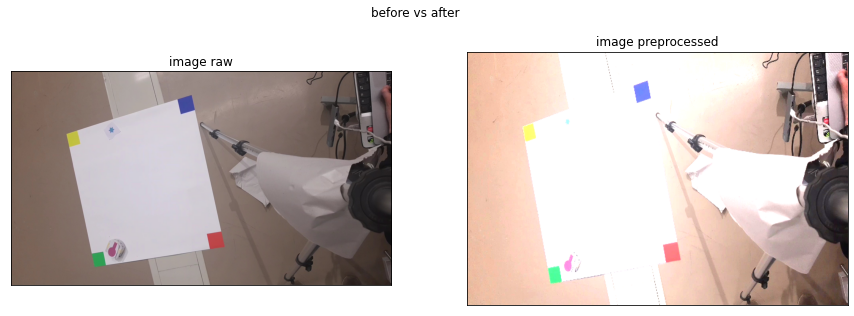

In [32]:
img = cv2.imread('sample_pictures/sample.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgprep = v.preprocess(img,(10,128))
imgprep_rgb = cv2.cvtColor(imgprep.get(), cv2.COLOR_HSV2RGB)


fig, (raw, prep) = plt.subplots(1, 2)
fig.set_size_inches(15,5)
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.suptitle('before vs after')

raw.imshow(img_rgb)
raw.set_title('image raw')


prep.imshow(imgprep_rgb)
prep.set_title('image preprocessed')
plt.show()

Once the image is preprocessed, each corner is selected using a colorfilter and a morphological opening to remove noise. The centroid of the resulting image is then used to get the center of each corner.
A possibility to use different cameras, changing a bit the hue value of the real color, was implemented (the camera variable in the following code). 
Note that when the centroid is still noisy, or if no pixel pass the filter, a flag is set to tell that the corner was not correctly detected.

invalid centroid: no pixel
YELLOW ERROR
invalid centroid:noise
RED ERROR


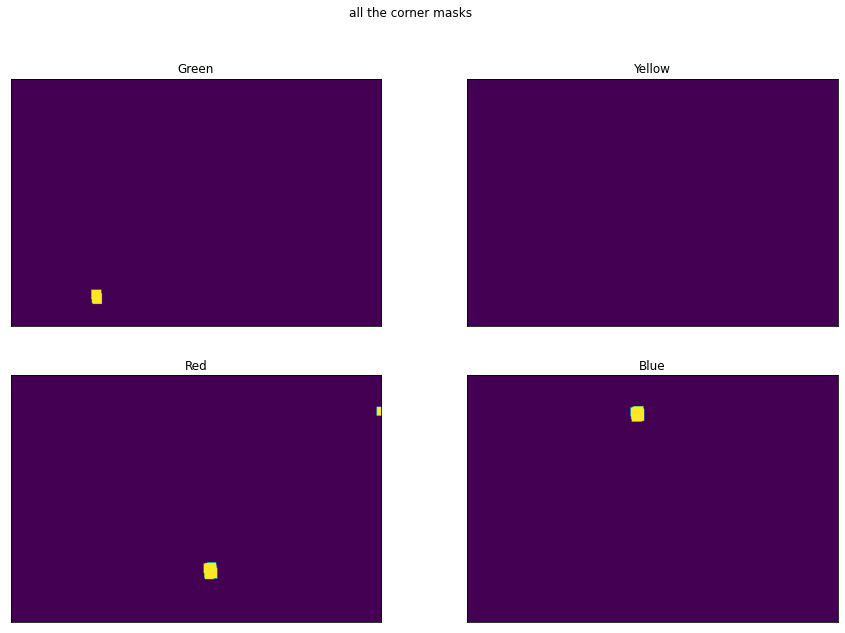

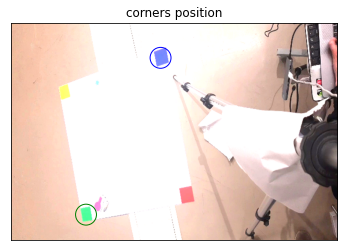

In [33]:
invalid = False
camera = "ANDROID FLASK"
filr = v.colorfilter("RED",camera)
filg = v.colorfilter("GREEN",camera)
filb = v.colorfilter("BLUE",camera)
fily = v.colorfilter("YELLOW",camera)

maskg= filg.get_mask(imgprep)
TL,fg = v.getCentroid(maskg)
if fg:
    print("GREEN ERROR")
    invalid = True

masky= fily.get_mask(imgprep)
TR,fy = v.getCentroid(masky)
if fy:
    print("YELLOW ERROR")
    invalid = True

maskr= filr.get_mask(imgprep)
BL,fr = v.getCentroid(maskr)
if fr:
    print("RED ERROR")
    invalid = True



maskb= filb.get_mask(imgprep)
BR,fb = v.getCentroid(maskb)
if fb:
    print("BLUE ERROR")
    invalid = True
    
fig, axs = plt.subplots(2,2)
fig.set_size_inches(15,10)
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.suptitle('all the corner masks')

axs[0,0].imshow(maskg.get())
axs[0,0].set_title('Green')

axs[0,1].imshow(masky.get())
axs[0,1].set_title('Yellow')

axs[1,0].imshow(maskr.get())
axs[1,0].set_title('Red')

axs[1,1].imshow(maskb.get())
axs[1,1].set_title('Blue')

fig,ax = plt.subplots()
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
ax.imshow(imgprep_rgb)
ax.set_title('corners position')
if  not fg:
    circle = plt.Circle(TL, 20, color='g',fill=False)
    ax.add_artist(circle)
if  not fy:
    circle = plt.Circle(TR, 20, color='y',fill=False)
    ax.add_artist(circle)

if  not fb:
    circle = plt.Circle(BR, 20, color='b',fill=False)
    ax.add_artist(circle)
    
if  not fr:
    circle = plt.Circle(BL, 20, color='r',fill=False)
    ax.add_artist(circle)
plt.show()


### Setting the parameters
As said before, the background and luminosity can change. To avoid any problem, the min and max luminosity can be changed at the begining of the program by activating a flag, otherwise, default values are calulated as being the 10th adn 90th percentiles of the image.

In [34]:
setextval = True
valext = np.percentile(img, (10, 90)).astype(int) #default value
if setextval:
    valext = v.adjustlum(img,valext)
    imgprep = v.preprocess(img,valext)
print("The selectect min and max are "+str(valext))

Select the equalization, then press v to validate


error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-b4ibzwe2/opencv/modules/highgui/src/window_QT.cpp:542: error: (-27:Null pointer) NULL guiReceiver (please create a window) in function 'cvDestroyWindow'


With some backgrounds, even a perfect preprocessing cannot differentiate the corner from some item. To handle such cases, a flag can be set in the initialisation to select the corners using a custom watershed algorithme, overwriting the invalid corners detected with the color filter

In [1]:
#same code as before, but this time allows manual selection
setmanually = True
invalid = False

filr = v.colorfilter("RED",camera)
filg = v.colorfilter("GREEN",camera)
filb = v.colorfilter("BLUE",camera)
fily = v.colorfilter("YELLOW",camera)


maskg= filg.get_mask(imgprep)
TL,fg = v.getCentroid(maskg)
if fg:
    print("GREEN ERROR")
    if setmanually:
        TL = v.manually_get_centroid(imgprep, preprocessed=True)
        fg = False

masky= fily.get_mask(imgprep)
TR,fy = v.getCentroid(masky)
if fy:
    print("YELLOW ERROR")
    if setmanually:
        TR = v.manually_get_centroid(imgprep, preprocessed=True)
        fy = False

maskr= filr.get_mask(imgprep)
BL,fr = v.getCentroid(maskr)
if fr:
    print("RED ERROR")
    if setmanually:
        BL = v.manually_get_centroid(imgprep, preprocessed=True)
        fr = False

maskb= filb.get_mask(imgprep)
BR,fb = v.getCentroid(maskb)
if fb:
    print("BLUE ERROR")
    if setmanually:
        BR = v.manually_get_centroid(imgprep, preprocessed=True)
        fb = False
        
        
#ploting everything
fig,ax = plt.subplots()
ax.imshow(imgprep_rgb)
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
ax.set_title('corners position')
if  not fg:
    circle = plt.Circle(TL, 20, color='g',fill=False)
    ax.add_artist(circle)
if  not fy:
    circle = plt.Circle(TR, 20, color='y',fill=False)
    ax.add_artist(circle)

if  not fb:
    circle = plt.Circle(BR, 20, color='b',fill=False)
    ax.add_artist(circle)
    
if  not fr:
    circle = plt.Circle(BL, 20, color='r',fill=False)
    ax.add_artist(circle)
plt.show()

NameError: name 'v' is not defined

Once all the corners are set, the projection matrix is calculated and projection matrix is stored for future use.
The resulting image is set to a 500 to 500 size, containing only the map. In the case the corners are found to be invalid, a previous transform (given in the argument) is returned. 
Note that on the following result image, some cyan points are found in the red corner. This is a probleme from matplotlib that occure when an 

In [2]:
prevtrans = np.identity(3)

NameError: name 'np' is not defined

In [3]:
transform, invalid = v.getTransformimage(img,camera,prevtrans,valext, setmanually = True)
if not invalid:
    imgreal = cv2.warpPerspective(imgprep, transform, (500,500),borderMode=cv2.BORDER_REFLECT_101)
    imgreal_rgb = cv2.cvtColor(imgreal,cv2.COLOR_HSV2RGB).get()
    prevtrans = transform
    fig,ax = plt.subplots()
    fig.set_size_inches(6,6)
    ax.imshow(imgreal_rgb)
    [ax.get_xaxis().set_visible(False) for ax in fig.axes]
    [ax.get_yaxis().set_visible(False) for ax in fig.axes]
    ax.set_title('internal frame')
    plt.show()
else:
    print("invalid transform")

NameError: name 'img' is not defined

### Obstacles 
Once the map is processed and stored, the obstacles are computed in the following steps:
* A color filter is applied on the map, selecting black pixels
* The obstacles are morphologically dilated 30 times by a 3x3 cross, increasing their size so the side of the robot does not touche them when getting too close
* A next dilation, this time by a 30x30 square, improve the shape of the obstacles when they are on the side of the map
* The obtained shapes are the approximated by polygons, using a margin of 15 pixels
The obstacles are then stored in a list and send to the global path calculation


In [4]:
#copy of v.createMap, to get the different steps
filter_poly = colorfilter("BLACK",camera)

maskpoly = filter_poly.get_mask(img)
# cv2.imshow("mask poly", maskpoly)
margin = cv2.dilate(maskpoly,cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))\
                    ,iterations = 30,borderType =cv2.BORDER_CONSTANT,borderValue = 0)
margin = cv2.dilate(margin,cv2.getStructuringElement(cv2.MORPH_RECT, (border_size,border_size))
                    ,iterations = 1,borderType = cv2.BORDER_CONSTANT,borderValue = 0)

polyprojbin = margin.get().astype(np.uint8)
contours, ret = cv2.findContours(polyprojbin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
polygons = []
for c in contours:
    polygon    =  cv2.approxPolyDP(c, 15, True)
    polygons.append(polygon)

NameError: name 'colorfilter' is not defined

## Path planning
The path planning module is takes as input the obstacles computed by the vision module and returns a shortest path through the obstacles, it performs the following operations to compute the path :

From the obstacles mapped by the vision a visibility graph is computed, dikjstra's algorithm is in turn run on the visibility graph and returns a shortest path, this path is then forwarded to the robot controler.

## Constructing the visibility graph

consider the following example map, together with a starting point and a goal, we describe all points in space a 2 float tuples :

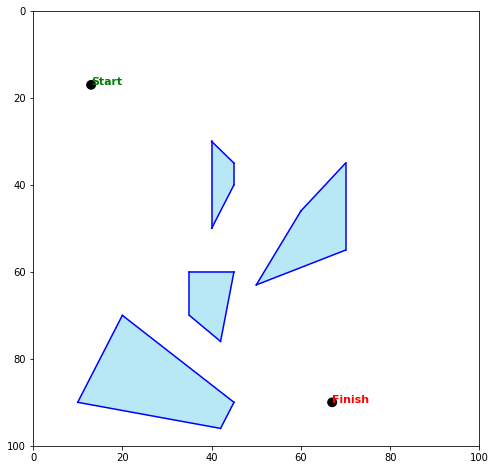

In [21]:
def complexMap():
        polyA = [(40.,30.),
                 (40.,50.),
                 (45.,40.),
                 (45.,35.)]

        polyB = [(70.,35.),
                 (60.,46.),
                 (50.,63.),
                 (70.,55.)]

        polyC = [(35.,60.),
                 (35.,70.),
                 (42.,76.),
                 (45.,60.)]

        polyD = [(20.,70.),
                 (10.,90.),
                 (42.,96.),
                 (45.,90.)]

        return [polyA,polyB,polyC,polyD]
    
start = (13.,17.)
goal = (67.,90.)
    
ut = u.Utilities()
ut.mapPlot(map = complexMap(),start=start, finish=goal)

We construct a visibility graph according to the following algorithm :

```

Let Q be an array containg the start vertex
Let U be an array containing of all vertices of polygons on the map and the goal vertex
Let E be an empty array of edges
Let V be an empty array of vertices

while Q not empty:
    pop h from Q (put the head of Q into h and remove it from Q)
    add h to V
    let N be the set of vertices in U that are neighbors of h
    for all vertices n in N:
        if it is possible to trace a segment from h to n without intersecting a polygon's border
            remove n from U and add it to Q
            append the edge (h,n) to E
            
return the G = (V,E)

```

This is implemented in the Global.py module

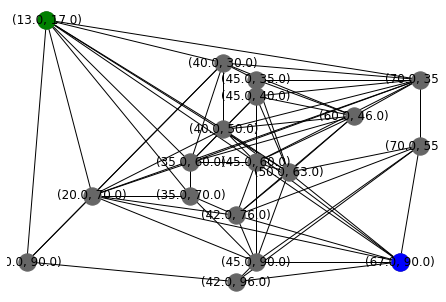

In [22]:
gl = g.Global(complexMap(), start, goal, margin = 3)
graph = gl.computeGraph()
gl.netPlot(graph,start = start, finish = goal)

## Computing the shortest path

The visibility graph is a weighted graph that represents the topology of the map, the weight of the edges are given by the distance between the nodes in space. Computing the physical shortest path for the robot can therefore be performed by finding a shortest path on the weighted visibility graph. This can be performed using Dikjstra's algorithm, if the graph was bigger it may have made sense to use A* to ensure good performance but the graphs here are small enough that it is of no significance.

The computation of the shortest path is implemented in the Global.py module using the networkx library for python. An example of shortest path can be seen below (shortest path plotted in red on the visibility graph).

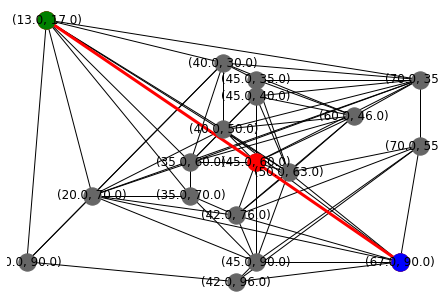

In [23]:
path = gl.returnPath(complexMap(),start,goal)
gl.netPlot(graph,start = start, finish = goal, path = path)

On a shortest path has been computed we return an ordered sequence of float tuples representing the positions the robot need to go through in order to navigate it's environnement optimallym this is in turn used by the robot's controller to guide the robot. An interactive example of path planning can be seen below :

In [34]:
def demo(sx=14.,sy=20.,gx=60.,gy=85.):
    gl.start = (sx,sy)
    gl.finish = (gx,gy)
    gl.plotPath(plotMap=True)
    
w = interactive(demo,sx=(0.,100.),sy=(0.,100.),gx=(0.,100.),gy=(0.,100.))
display(w)

interactive(children=(FloatSlider(value=14.0, description='sx'), FloatSlider(value=20.0, description='sy'), Fl…